In [1]:
import pandas as pd
import numpy as np

# Некоторые преобразования и 'первичный осмотр' данных.

In [2]:
df = pd.read_csv(r"C:\Users\bas41\Downloads\train kaggle.csv")
test = pd.read_csv(r"C:\Users\bas41\Downloads\test.csv")
df = df.drop(columns='id')

df.head(10)

,age,sex,bmi,children,smoker,region,charges
0,43,male,26.030,0,no,northeast,6837.36870
1,58,female,28.215,0,no,northwest,12224.35085
2,53,male,31.350,0,no,southeast,27346.04207
3,54,male,29.200,1,no,southwest,10436.09600
4,19,male,34.900,0,yes,southwest,34828.65400
5,39,female,22.800,3,no,northeast,7985.81500
6,51,male,25.400,0,no,southwest,8782.46900
7,25,male,29.700,3,yes,southwest,19933.45800
8,62,male,37.400,0,no,southwest,12979.35800
9,23,female,33.400,0,no,southwest,10795.93733


Из-за того, что в данных есть категориальные фичи, нужно предобработать датасет: изменим столбец `sex` в датасете (если пол мужской - 1, иначе 0), в столбце `smoker` будем ставить единицу, если человек курит, и ноль в противном случае. Обработаем места жительства: создадим новые столбцы `north` и `east` и закодируем место жительства каждого индивида. Кроме этого, из-за того, что метрика в задаче - это $RMSLE = \sqrt{\frac{1}{n} \sum_i^n (log(\hat{y}_i + 1) - log(y_i + 1))^2}$, мы можем логарифмировать целевую переменную, чтобы метрика превратилась в обычную $RMSE = \sqrt{\frac{1}{n} \sum_i^n (\hat{y}_i - y_i)^2}$:

In [3]:
def good_appearance(df_: pd.DataFrame, lin_reg=False):
    df = df_.copy()
    df['male'] = np.int8(df['sex'] == 'male')
    del df['sex']
    df['smoker'] = np.int8(df['smoker'] == 'yes')
    df['north'] = np.int8(list(map(lambda x: x[:5] == 'north', df['region'])))
    df['east'] = np.int8(list(map(lambda x: x[-4:] == 'east', df['region'])))
    del df['region']

    if 'Unnamed: 0' in df.columns:
        del df['Unnamed: 0']
    if 'charges' in df.columns:
        df['log(charges)'] = np.log1p(df['charges'])
        del df['charges']
    return df

df_good = good_appearance(df)
test_good = good_appearance(test)
df_good

,age,bmi,children,smoker,male,north,east,log(charges)
0,43,26.030,0,0,1,1,1,8.830304
1,58,28.215,0,0,0,1,0,9.411267
2,53,31.350,0,0,1,0,1,10.216364
3,54,29.200,1,0,1,0,0,9.253122
4,19,34.900,0,1,1,0,0,10.458224
...,...,...,...,...,...,...,...,...
664,18,31.350,4,0,0,1,1,8.425558
665,39,23.870,5,0,0,0,1,9.057574
666,58,25.175,0,0,1,1,1,9.386990
667,37,47.600,2,1,0,0,0,10.738883


In [4]:
print('Столбцы в подкорректированном датасете:', list(df_good.columns))
print('Описание столбцов:')
df_good.describe()

Столбцы в подкорректированном датасете: ['age', 'bmi', 'children', 'smoker', 'male', 'north', 'east', 'log(charges)']
Описание столбцов:


,age,bmi,children,smoker,male,north,east,log(charges)
count,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000,669.000000
mean,39.064275,30.373744,1.091181,0.191330,0.502242,0.514200,0.526158,9.081479
std,14.324314,6.016210,1.210878,0.393643,0.500369,0.500172,0.499689,0.905482
min,18.000000,15.960000,0.000000,0.000000,0.000000,0.000000,0.000000,7.036500
25%,27.000000,26.030000,0.000000,0.000000,0.000000,0.000000,0.000000,8.465490
50%,39.000000,30.115000,1.000000,0.000000,1.000000,1.000000,1.000000,9.129809
75%,52.000000,34.300000,2.000000,0.000000,1.000000,1.000000,1.000000,9.669138
max,64.000000,53.130000,5.000000,1.000000,1.000000,1.000000,1.000000,11.044423


# EDA

Проведем небольшой графический и аналитический анализ данных и фичей. Сначала посмотрим на корреляционную матрицу признаков между друг другом и логарифмом страховых взносов.

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

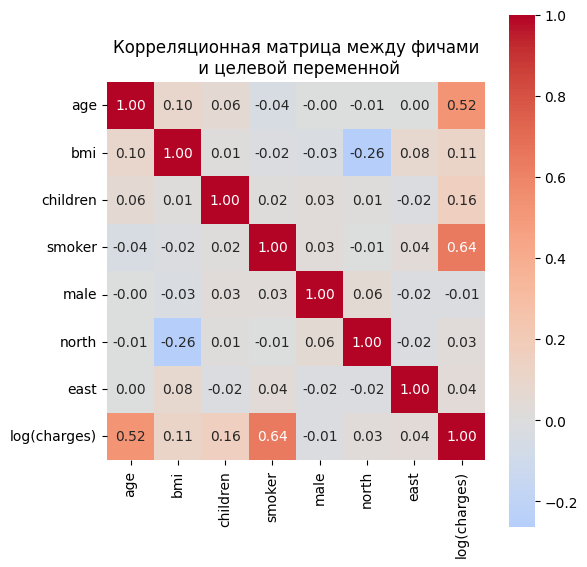

In [6]:
plt.figure(figsize=(6, 6))
sns.heatmap(df_good.corr(), 
            annot=True,
            cmap='coolwarm',
            center=0,
            square=True,
            fmt='.2f')
plt.title('Корреляционная матрица между фичами\n и целевой переменной')
plt.tight_layout()
plt.show()

Теперь посмотрим на распределение затрат на страховку в зависимости от возраста. Красным выделены курильщики, синим некурящие.

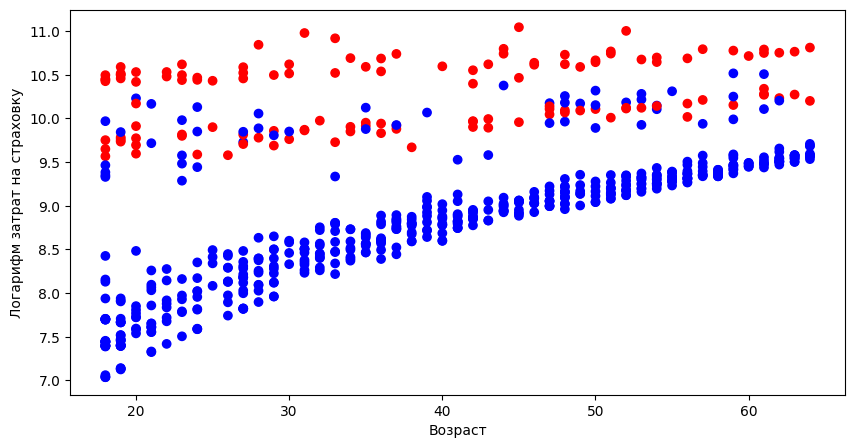

In [7]:
plt.figure(figsize=(10, 5))
plt.scatter(df_good.loc[:, 'age'], df_good.loc[:, 'log(charges)'], c=df_good.loc[:, 'smoker'], cmap='bwr')
plt.xlabel('Возраст')
plt.ylabel('Логарифм затрат на страховку')
plt.show()

Этот график показывает распределение расходов в зависимости от ИМТ. Цвета обозначают то же, что и на предыдущем графике.

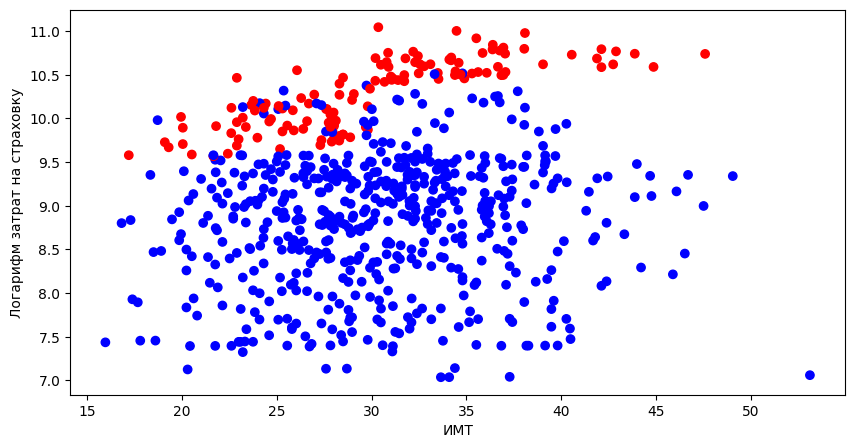

In [8]:
plt.figure(figsize=(10, 5))
plt.scatter(df_good.loc[:, 'bmi'], df_good.loc[:, 'log(charges)'], c=df_good.loc[:, 'smoker'], cmap='bwr')
plt.xlabel('ИМТ')
plt.ylabel('Логарифм затрат на страховку')
plt.show()

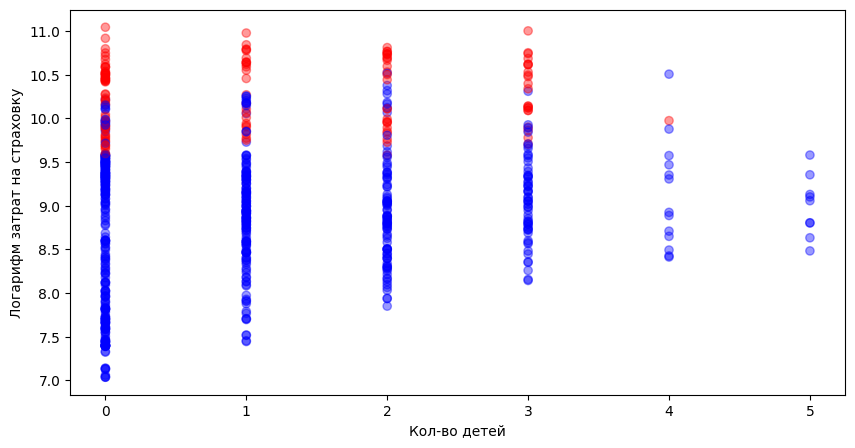

In [9]:
plt.figure(figsize=(10, 5))
plt.scatter(df_good.loc[:, 'children'], df_good.loc[:, 'log(charges)'], c=df_good.loc[:, 'smoker'], cmap='bwr', alpha=0.4)
plt.xlabel('Кол-во детей')
plt.ylabel('Логарифм затрат на страховку')
plt.show()

Проведем некоторую работу с признаковыми описаниями объектов. Добавим взаимодействия признаков между собой (категориальных с непрерывными и непрерывных с непрерывными), добавим квадраты возраста и ИМТ, а также логарифмы этих фичей. \
\
Впоследствии мы хотим использовать такие модели, как KNN, линейную регрессию (в том числе с регуляризацией), дерево решений и случайный лес. Несмотря на то, что монотонные преобразования не должны оказать значимого влияния на качество моделей, основанных на деревьях, они могут помочь заметить зависимости в линейных регрессиях, на что мы и делаем расчет.

In [10]:
def add_features_ln(df_: pd.DataFrame):
    df = df_.copy()

    # Взаимодействия фичей
    df['age*bmi'] = df['age'] * df['bmi']
    df['age*children'] = df['age'] * df['children']
    df['bmi*children'] = df['bmi'] * df['children']
    df['smoker*bmi'] = df['smoker'] * df['bmi']
    df['age*smoker'] = df['age'] * df['smoker']
    df['male*bmi'] = df['male'] * df['bmi']
    
    # Квадраты фичей
    df['age**2'] = df['age'] ** 2
    df['bmi**2'] = df['bmi'] ** 2

    # Логарифмы
    df['log2(age)'] = np.log2(df['age'])
    df['log2(bmi)'] = np.log2(df['bmi'])

    feature_columns = [el for el in list(df.columns) if el != 'log(charges)']
    
    return df, feature_columns

df_features_ln, feature_ln_columns = add_features_ln(df_good)
test_features_ln, _ = add_features_ln(test_good)

df_features_ln

,age,bmi,children,smoker,male,north,east,log(charges),age*bmi,age*children,bmi*children,smoker*bmi,age*smoker,male*bmi,age**2,bmi**2,log2(age),log2(bmi)
0,43,26.030,0,0,1,1,1,8.830304,1119.29,0,0.00,0.0,0,26.030,1849,677.560900,5.426265,4.702103
1,58,28.215,0,0,0,1,0,9.411267,1636.47,0,0.00,0.0,0,0.000,3364,796.086225,5.857981,4.818390
2,53,31.350,0,0,1,0,1,10.216364,1661.55,0,0.00,0.0,0,31.350,2809,982.822500,5.727920,4.970394
3,54,29.200,1,0,1,0,0,9.253122,1576.80,54,29.20,0.0,0,29.200,2916,852.640000,5.754888,4.867896
4,19,34.900,0,1,1,0,0,10.458224,663.10,0,0.00,34.9,19,34.900,361,1218.010000,4.247928,5.125155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
664,18,31.350,4,0,0,1,1,8.425558,564.30,72,125.40,0.0,0,0.000,324,982.822500,4.169925,4.970394
665,39,23.870,5,0,0,0,1,9.057574,930.93,195,119.35,0.0,0,0.000,1521,569.776900,5.285402,4.577127
666,58,25.175,0,0,1,1,1,9.386990,1460.15,0,0.00,0.0,0,25.175,3364,633.780625,5.857981,4.653920
667,37,47.600,2,1,0,0,0,10.738883,1761.20,74,95.20,47.6,37,0.000,1369,2265.760000,5.209453,5.572890


# Создание модели

Идея модели заключается в том, что мы используем кросс-валидацию для каждой из четырех моделей, описанных выше, а затем применяем стекинг. Мы выбираем, скажем, 5 фолдов, 1 из которых - тестовый (для определенности будем говорить, что это все-таки валидационный фолд). Во время кросс-валидации мы обучаем каждую из базовых моделей на тренировочных $5-1$ фолдах, а затем получаем предсказания на 1 валидационном фолде и записываем это в массив `oof_df`, на котором будет обучаться мета-модель (в нашем случае линейная регрессия). Кроме этого, для каждой модели мы усредняем предсказания для тестовой выборки. \
Далее у нас оказывается датафрейм `oof_df`, который мы разбиваем на тренировочную и валидационную выборки. Сначала мета-модель обучается только на тренировочной выборке, а качество замеряется на валидационной и выводится пользователю. Затем модель обучается снова, но уже на всем наборе `oof_df`, и мы получаем предсказания для тестовой выборки, которые функция `stacking` и возвращает.

In [11]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV, train_test_split

In [12]:
def stacking(
    df_train,
    df_test,
    train_y,
    n, md, mss, mf,      # гиперпараметры для леса
    a,                   # гиперпараметр для регрессии с регуляризацией
    k,                   # гиперпараметр для KNN
    mdt, mslt, msst, c,   # гиперпараметры для дерева
    n_splits=5, 
    random_state=42,
    metric=root_mean_squared_error
):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # OOF ответы
    oof_df = pd.DataFrame()
    oof_df["target"] = train_y
    oof_df["prediction_RFR"] = np.zeros(oof_df.shape[0])
    oof_df["prediction_KNN"] = np.zeros(oof_df.shape[0])
    oof_df["prediction_Ridge"] = np.zeros(oof_df.shape[0])
    oof_df["prediction_Tree"] = np.zeros(oof_df.shape[0])
    
    # Датафрейм для тестовой выборки
    test_df = pd.DataFrame()
    test_df["prediction_RFR"] = np.zeros(df_test.shape[0])
    test_df["prediction_KNN"] = np.zeros(df_test.shape[0])
    test_df["prediction_Ridge"] = np.zeros(df_test.shape[0])
    test_df["prediction_Tree"] = np.zeros(df_test.shape[0])

    fold = 1
    # Кросс-валидация с предсказанием для OOF
    for train_index, valid_index in kf.split(df_train, train_y):
        print('Фолд', fold)
        fold += 1
        
        X_train = df_train.loc[train_index]
        y_train = train_y.loc[train_index].values

        X_valid = df_train.loc[valid_index]
        y_valid = train_y.loc[valid_index].values

        preprocessor = ColumnTransformer([
            ('scaler', StandardScaler(), ['age', 'bmi', 'children', 'age*bmi', 'age*children', 'bmi*children', 'smoker*bmi', 'age*smoker', 'male*bmi', 'age**2', 'bmi**2', 'log2(age)', 'log2(bmi)']),
            ('passthrough', 'passthrough', ['male', 'smoker', 'north', 'east'])
        ])

        ### Инициализация всех базовых моделей ###
        knn = Pipeline([
            ('scaler', preprocessor),
            ('model', KNeighborsRegressor(n_neighbors=k))
        ])
        ridge = Pipeline([
            ('scaler', preprocessor),
            ('model', Ridge(alpha=a))
        ])
        tree = DecisionTreeRegressor(criterion=c, max_depth=7, min_samples_leaf=9, min_samples_split=2)
        rfr = RandomForestRegressor(n_estimators=n, max_depth=md, min_samples_split=mss, max_features=mf, random_state=42)
        
        ### Обучение всех базовых моделей на 4 фолдах ###
        rfr.fit(X_train, y_train)
        knn.fit(X_train, y_train)
        ridge.fit(X_train, y_train)
        tree.fit(X_train, y_train)
        
        ### Предсказания всех моделей для пятого фолда ###
        prediction_rfr = rfr.predict(X_valid)
        pred_knn = knn.predict(X_valid)
        pred_ridge = ridge.predict(X_valid)
        pred_tree = tree.predict(X_valid)
        oof_df.loc[valid_index, "prediction_RFR"] = prediction_rfr
        oof_df.loc[valid_index, "prediction_KNN"] = pred_knn
        oof_df.loc[valid_index, "prediction_Ridge"] = pred_ridge
        oof_df.loc[valid_index, "prediction_Tree"] = pred_tree
        
        ### Усредняем предсказания по всем моделям для тестовой выборки ###
        pred_rfr = rfr.predict(df_test) / n_splits
        pred_knn = knn.predict(df_test) / n_splits
        pred_ridge = ridge.predict(df_test) / n_splits
        pred_tree = tree.predict(df_test) / n_splits
        test_df.loc[:, "prediction_RFR"] += pred_rfr
        test_df.loc[:, "prediction_KNN"] += pred_knn
        test_df.loc[:, "prediction_Ridge"] += pred_ridge
        test_df.loc[:, "prediction_Tree"] += pred_tree
        
    
    ### Инициализируем и обучаем мета-модель -- линейную регрессию ###
    meta_model = LinearRegression()
    x_train, x_val, y_train, y_val = train_test_split(oof_df.loc[:, [el for el in oof_df.columns if el != 'target']], oof_df.loc[:, 'target'], test_size=0.2, random_state=42)
    meta_model.fit(x_train, y_train)
    predict = meta_model.predict(x_val)
    ### Проверяем качество мета-модели на валидационной выборке, а затем обучаем на всех доступных данных и получаем предсказания для тестовой ###
    print('Ошибка мета-модели на валидационной выборке:', root_mean_squared_error(y_val, predict))
    meta_model = LinearRegression()
    meta_model.fit(oof_df.loc[:, ["prediction_RFR", "prediction_KNN", "prediction_Ridge", "prediction_Tree"]], oof_df.loc[:, 'target'])
    pred_test = meta_model.predict(test_df)

    return pred_test

## Ищем лучшие гиперпараметры для базовых моделей.

In [13]:
x_train, x_test, y_train, y_test = train_test_split(df_features_ln.loc[:, feature_ln_columns], df_features_ln.loc[:, 'log(charges)'],
                                                        test_size=0.2, random_state=42, shuffle=True)

### KNN

In [14]:
grid = {
    'model__n_neighbors': range(2, 30),
    'model__weights': ['uniform', 'distance'],
    'model__p': [1, 2]
}

preprocessor = ColumnTransformer([
    ('scaler', StandardScaler(), ['age', 'bmi', 'children', 'age*bmi', 'age*children', 'bmi*children', 'smoker*bmi', 'age*smoker', 'male*bmi', 'age**2', 'bmi**2', 'log2(age)', 'log2(bmi)']),
    ('passthrough', 'passthrough', ['male', 'smoker', 'north', 'east'])
])

knn_pipeline = Pipeline([
        ('scaler', preprocessor),
        ('model', KNeighborsRegressor())
    ])

knn_grid = GridSearchCV(
    knn_pipeline,
    param_grid=grid,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    verbose=1
)

knn_grid.fit(x_train, y_train)
print('Лучший скор на CV:', -knn_grid.best_score_)
print('Лучшие параметры для KNN:', knn_grid.best_params_)

Fitting 5 folds for each of 112 candidates, totalling 560 fits
Лучший скор на CV: 0.4512034910892247
Лучшие параметры для KNN: {'model__n_neighbors': 17, 'model__p': 2, 'model__weights': 'uniform'}


### Дерево решений

In [15]:
grid_tree = {
    'criterion': ['squared_error', 'friedman_mse'],
    'max_depth': range(1, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

tree_grid = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid=grid_tree,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    verbose=1
)

tree_grid.fit(x_train, y_train)
print('Лучший скор на CV:', -tree_grid.best_score_)
print('Лучшие параметры для DTR:', tree_grid.best_params_)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
Лучший скор на CV: 0.43768372585602633
Лучшие параметры для DTR: {'criterion': 'squared_error', 'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 2}


### Линейная регрессия с L2-регуляризацией

In [16]:
cv = RidgeCV(alphas=[1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 2, 3, 5, 10, 15, 20, 40, 50, 100, 200, 400, 800, 1000])
cv.fit(x_train, y_train)
print('Качество на валидационной выборке:', root_mean_squared_error(y_test, cv.predict(x_test)))
print('При параметре alpha =', cv.alpha_)

Качество на валидационной выборке: 0.3376452738708287
При параметре alpha = 0.01


### Случайный лес

In [17]:
rfr_grid = {
    'max_depth': range(1, 10),
    'min_samples_split': range(10, 20),
    'max_features': [float(el) for el in np.linspace(0.1, 1, 5)],
}

rfr = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=rfr_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=1,
    verbose=2
)

rfr.fit(x_train, y_train)

print('Лучший скор на CV:', -rfr.best_score_)
print('Лучшие параметры для DTR:', rfr.best_params_)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
[CV] END max_depth=1, max_features=0.1, min_samples_split=10; total time=   0.0s


[CV] END max_depth=1, max_features=0.1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, max_features=0.1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, max_features=0.1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, max_features=0.1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=1, max_features=0.1, min_samples_split=11; total time=   0.0s
[CV] END max_depth=1, max_features=0.1, min_samples_split=11; total time=   0.0s
[CV] END max_depth=1, max_features=0.1, min_samples_split=11; total time=   0.0s
[CV] END max_depth=1, max_features=0.1, min_samples_split=11; total time=   0.0s
[CV] END max_depth=1, max_features=0.1, min_samples_split=11; total time=   0.0s
[CV] END max_depth=1, max_features=0.1, min_samples_split=12; total time=   0.0s
[CV] END max_depth=1, max_features=0.1, min_samples_split=12; total time=   0.0s
[CV] END max_depth=1, max_features=0.1, min_samples_split=12; total time=   0.0s
[CV] END max_depth=1, max_fe

In [18]:
from IPython.display import clear_output

501 деревьев


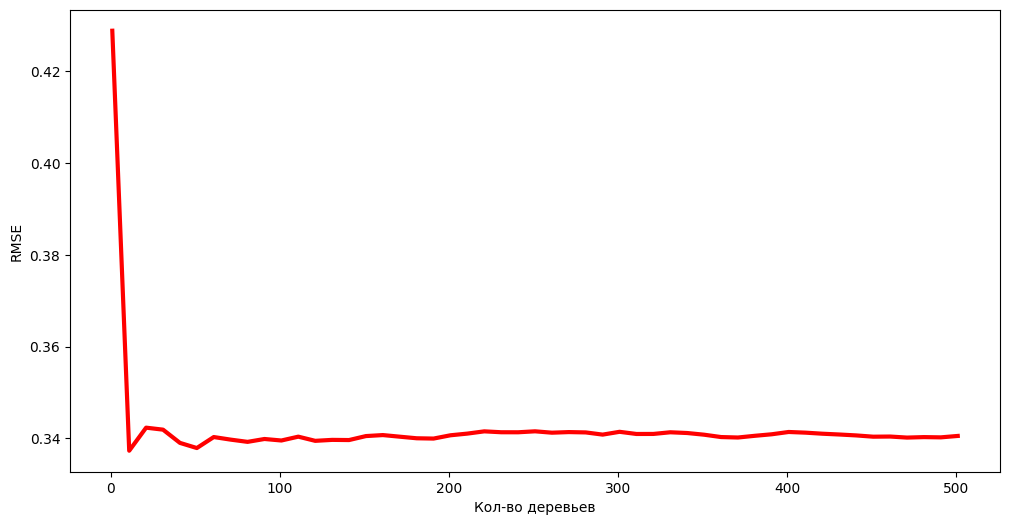

In [19]:
metric = []
for i in range(1, 502, 10):
    clear_output(True)
    print(i, 'деревьев')
    trees = RandomForestRegressor(n_estimators=i, max_depth=4, max_features=0.325, min_samples_split=13, random_state=42)
    trees.fit(x_train, y_train)
    metric.append(root_mean_squared_error(y_test, trees.predict(x_test)))

plt.figure(figsize=(12, 6))
plt.plot(list(range(1, 502, 10)), metric, linewidth=3, c='red')
plt.xlabel('Кол-во деревьев')
plt.ylabel('RMSE')
plt.show() 

# Финальное предсказание и проверка модели

In [20]:
pred = stacking(df_train=df_features_ln.loc[:, feature_ln_columns],
                df_test=test_features_ln.loc[:, feature_ln_columns],
                train_y=df_features_ln.loc[:, 'log(charges)'],
                n=100, md=4, mss=13, mf=0.325,
                a=0.01,
                k=17,
                mdt=4, msst=2, mslt=9, c='squared_error',
                n_splits=5,
                random_state=42,
                metric=root_mean_squared_error)

Фолд 1
Фолд 2
Фолд 3
Фолд 4
Фолд 5
Ошибка мета-модели на валидационной выборке: 0.3296125556824112


In [21]:
def final_ans(y_pred, y_true):
    print('=' * 50)
    print('Финальный результат модели на тестовой выборке')
    print('=' * 50)
    print('|' + " " * 48 + '|')
    print('|' + ' ' * 21 + f'{np.round(root_mean_squared_error(y_true, y_pred), 4)}' + ' ' * 21 + '|')
    print('|' + " " * 48 + '|')
    print('=' * 50)
    return np.exp(y_pred)

In [22]:
answer = final_ans(pred, test_features_ln.loc[:, 'log(charges)'])
print('Сами ответы:')
answer

Финальный результат модели на тестовой выборке
|                                                |
|                     0.3555                     |
|                                                |
Сами ответы:


array([ 9226.3292529 ,  5491.6476835 , 27758.99463016,  9060.76905709,
       29903.75025763,  5477.3117576 ,  2337.80326547, 14716.29728596,
        4213.34286379, 11592.13332274, 20554.63885134,  7644.07070882,
        4865.02136239, 55443.90174801, 50157.71984257, 50406.80549274,
       10606.5810306 , 46790.17175562,  8574.09985947, 26003.26825344,
        4723.52967414,  8259.44390395,  2080.57508022,  2722.23986079,
       12398.35888728, 12467.96315211, 13313.18897344,  5322.13251369,
       10719.02250685,  2150.02126836,  8119.73385211, 12789.23415998,
        2566.14111705,  5625.86429685,  3933.16906142,  8427.60137376,
        3181.63138735,  7751.8143122 , 25729.05396697, 42768.64713593,
        4650.14072945,  3585.84809618, 12220.40537209, 12569.40356407,
        5967.8903789 , 12630.03385775,  4279.7094411 ,  4687.48306537,
       48462.01808537,  5628.5506044 , 14315.08669428,  2515.68585216,
        6961.28951466,  2296.3219289 , 12066.07585425, 11879.42676976,
      